# Generative models for protein sequences
## Authors: Eren Bardak, Daniel Gonzalez
### In this notebook we investigate two different methods for generating novel protein sequences. In the first part, we extended and fine-tuned the [Struct2Seq](https://github.com/jingraham/neurips19-graph-protein-design) model which leverages a Transformer and Message Passing Neural Network (instead of attention) to predict novel [Multiple Sequence Alignments](https://en.wikipedia.org/wiki/Multiple_sequence_alignment) from a given protein sequence. In the second part, we extend and fine-tune [ProtGPT2](https://huggingface.co/nferruz/ProtGPT2/blob/main/README.md) to predict completely novel protein sequences.
Install required packages before beginning:

In [1]:
# !pip install biopython
# !pip install nglview
# !conda install -c conda-forge nglview

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import nglview as nv
from Bio.PDB import PDBParser
import json
import matplotlib.pyplot as plt
import nglview as nv
from IPython.display import display as ipy_display
import ipywidgets as widgets
import warnings
warnings.filterwarnings('ignore')

## Dataset download
### The [ProteinNet CASP12 dataset](https://github.com/aqlaboratory/proteinnet/tree/master) is large ASCII encoded file of protein sequences paired with PSSM and other structural information. Documentation is available at the above link. First we will need to parse this data into a useable format.

In [3]:
def parse_protein_data(file_path, n):
    # Initialize lists to store data
    ids = []
    sequences = []
    evolutionary = []
    tertiary = []
    masks = []
    
    # Initialize counters and temporary storage for current protein data
    current_protein = {}
    count = 0
    
    with open(file_path, 'r') as file:
        for line in tqdm(file):
            line = line.strip()
            if line.startswith('[ID]'):
                # Save previous protein data if exists
                if current_protein:
                    ids.append(current_protein.get('ID', ''))
                    sequences.append(current_protein.get('PRIMARY', ''))
                    evolutionary.append(current_protein.get('EVOLUTIONARY', []))
                    tertiary.append(current_protein.get('TERTIARY', []))
                    masks.append(current_protein.get('MASK', ''))
                    count += 1
                    # Break the loop if the required number of proteins have been parsed
                    if count >= n:
                        break
                    current_protein = {}
            
            # Identify the section and append the data to the current protein
            if line.startswith('['):
                key = line[1:line.find(']')]
                current_protein[key] = []
            elif current_protein:
                # Split TSV data into lists of floats or keep as strings depending on the section
                if key in ['EVOLUTIONARY', 'TERTIARY']:
                    # Split the line by spaces, convert each item to float
                    current_protein[key].append([float(x) for x in line.split()])
                else:
                    current_protein[key].append(line)
                
    # Check if last processed protein needs to be added
    if count < n and current_protein:
        ids.append(current_protein.get('ID', ''))
        sequences.append(current_protein.get('PRIMARY', ''))
        evolutionary.append(current_protein.get('EVOLUTIONARY', []))
        tertiary.append(current_protein.get('TERTIARY', []))
        masks.append(current_protein.get('MASK', ''))
    
    # Create DataFrame
    df = pd.DataFrame({
        'ID': ids,
        'Sequence': sequences,
        'Evolutionary': evolutionary,
        'Tertiary': tertiary,
        'Mask': masks
    })
    
    return df

### Load the data into a df. We used the training_100 for fine tuning, but loaded the training_30 (which contains 30% of the full dataset) as an example.

In [4]:
file_path = './data/training_30'
number_of_proteins = 50000  # Set how many proteins you want to load
protein_df = parse_protein_data(file_path, number_of_proteins)
protein_df.head(2)

834867it [00:29, 28693.81it/s]


,ID,Sequence,Evolutionary,Tertiary,Mask
0,[4W8Q_1_A],[NGIVPDAGHQGPDVSAVNGGTQVINIVTPNNEGISHNQYQDFNVG...,"[[0.0, 0.0, 0.0, 0.003620273531777957, 0.05267...","[[8667.0, 8744.7, 8693.8, 8561.7, 8507.4, 8541...",[+++++++++++++++++++++++++++++++++++++++++++++...
1,[2J58_1_A],[ATIIPGQGLNSLRKNVVELPDSDYDLDKLVNVYPMTPGLIDQLRP...,"[[0.05, 0.0, 0.0, 0.013847675568743818, 0.0, 0...","[[2309.3, 2397.7, 2539.4, 2627.5, 2769.0, 2861...",[+++++++++++++++++++++++++++++++++++++++++++++...


In [5]:
print("Number of proteins loaded:",len(protein_df))

Number of proteins loaded: 25299


### The secondary parser updates the types and dimensions of several variables to allow for easier processing:

In [6]:
def process_dataframe(df):
    # Convert ID, Sequence, and Mask to string directly
    df['ID'] = df['ID'].apply(lambda x: ''.join(x))
    df['Sequence'] = df['Sequence'].apply(lambda x: ''.join(x))
    df['Mask'] = df['Mask'].apply(lambda x: ''.join(x).replace('+', '1').replace('-', '0'))

    # Initialize columns for coordinates and amino acids
    coord_columns = ['x', 'y', 'z']
    aa_columns = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y','Info']

    # Expand tertiary coordinates
    for i, col in enumerate(coord_columns):
        df[col] = df['Tertiary'].apply(lambda x: x[i] if len(x) > i else None)

    # Expand evolutionary data into separate columns for each amino acid position
    for i, col in enumerate(aa_columns):
        df[col] = df['Evolutionary'].apply(lambda x: x[i] if len(x) > i else None)

    # Drop the original Tertiary and Evolutionary columns
    df.drop(['Tertiary', 'Evolutionary'], axis=1, inplace=True)

    return df

In [7]:
# Example usage:
processed_df = process_dataframe(protein_df)
processed_df.head(2)

,ID,Sequence,Mask,x,y,z,A,C,D,E,...,N,P,Q,R,S,T,V,W,Y,Info
0,4W8Q_1_A,NGIVPDAGHQGPDVSAVNGGTQVINIVTPNNEGISHNQYQDFNVGK...,1111111111111111111111111111111111111111111111...,"[8667.0, 8744.7, 8693.8, 8561.7, 8507.4, 8541....","[220.7, 313.5, 320.5, 325.9, 345.5, 481.0, 583...","[2297.8, 2216.1, 2071.6, 2056.4, 1922.2, 1860....","[0.0, 0.0, 0.0, 0.003620273531777957, 0.052679...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.007...","[0.0, 0.0, 0.0, 0.0, 0.0778237933244589, 0.159...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.015286944949013542...",...,"[0.9999999999999999, 0.0, 0.0, 0.0, 0.03705073...","[0.0, 0.0, 0.0, 0.0, 0.6938815757037914, 0.072...","[0.0, 0.0, 0.0, 0.0, 0.006507913030616773, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.001870402676114598...","[0.0, 0.0, 0.0, 0.0, 0.005743726273233743, 0.0...","[0.0, 0.0, 0.0, 0.004424778761061947, 0.000640...","[0.0, 0.0, 0.2848732624693377, 0.7300884955752...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001...","[0.9999999988691709, 0.9999999988691709, 0.683..."
1,2J58_1_A,ATIIPGQGLNSLRKNVVELPDSDYDLDKLVNVYPMTPGLIDQLRPE...,1111111111111111111111111111111111111111111111...,"[2309.3, 2397.7, 2539.4, 2627.5, 2769.0, 2861....","[12053.4, 11937.9, 11979.8, 11789.8, 11789.8, ...","[1185.1, 1201.8, 1162.6, 1307.8, 1353.3, 1234....","[0.05, 0.0, 0.0, 0.013847675568743818, 0.0, 0....","[0.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0190545...","[0.05, 0.0, 0.0, 0.010880316518298716, 0.0, 0....",...,"[0.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.012617083741...","[0.05, 0.0, 0.0, 0.0, 0.987119353442055, 0.0, ...","[0.05, 0.0, 0.0, 0.003297065611605671, 0.0, 0....","[0.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0272455...","[0.05, 0.0, 0.0, 0.005793415288964251, 0.0, 0....","[0.05, 1.0, 0.0, 0.00923178371249588, 0.005159...","[0.05, 0.0, 0.4501113275814083, 0.357590316047...","[0.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.05, 0.0, 0.0, 0.0012246243700249637, 0.0, 0...","[0.0, 0.9999999988691709, 0.6918268592985294, ..."


## Data description:
- ID is the protein name
- Sequence is the amino acid sequence using the single letter code
- Mask (same length as sequence) is a binary representation of how importatnt each amino acid is to the structure (that is, amino acids marked `0` can be changed without affecting the structure much, whereas amino acids marked `1` would significantly alter structure/function).
- XYZ are the coordinates of each atom (note there are 3 atoms per amino acid, Nitrogen, alpha-Carbon, and Carbon, so there are 3 times as many coordinates as amino acids in the sequence)
- The 20 columns A-Y are normalized PSSM information for each amino acid. This is essentially a sparse matrix where there is a row for each position in the protein sequence, and a column for each of the 20 amino acids.
- Info contains the information content for that residue (unclear what this actually is)
## Note:
Proteins are chains of amino acids, and each amino acid has a backbone of three atoms, N-C-C, which are always linked in the N to C direction: 

`Beginning of protein sequence amino acids:       1       2       3    ... etc`

`Beginning of protein sequence backbone atoms: (N-C-C)-(N-C-C)-(N-C-C)-... etc`

So in our final output, we need to have xyz coordinates for each of the three atoms, in order, for every amino acid.

## The third parsing step turns a row of our dataframe into a PDB file that can be viewed with NGL. Note that our dataset doesn't have info on the secondary structure, so these structures will not appear bolded in the output. 

The PDB specification is available here: https://www.biostat.jhsph.edu/~iruczins/teaching/260.655/links/pdbformat.pdf

In [8]:
def format_pdb_from_df(row):
    pdb_str = ""
    atom_count = 1  # Starting index for ATOM records
    chain_id = 'A'  # Assuming a single chain for simplicity
    res_num = 1     # Residue number
    occupancy = 1.00
    t_factor = 50.00

    atom_types = ['N', 'CA', 'C']  # Backbone atoms
    element_types = {'N': 'N', 'CA': 'C', 'C': 'C'}  # Elements for atoms
    residue_mapping = {'A': 'ALA','R': 'ARG','N': 'ASN','D': 'ASP','C': 'CYS','E': 'GLU','Q': 'GLN','G': 'GLY',
                       'H': 'HIS','I': 'ILE','L': 'LEU','K': 'LYS','M': 'MET','F': 'PHE','P': 'PRO','S': 'SER',
                       'T': 'THR','W': 'TRP','Y': 'TYR','V': 'VAL' } # PDB requires the 3 letter codes for amino acids

    for i in range(len(row['Sequence'])):
        residue = residue_mapping[row['Sequence'][i]]
        # Loop over each backbone atom type
        for j, atom_type in enumerate(atom_types):
            # Index to pull the correct coordinates from flattened list
            idx = 3 * i + j
            x = row['x'][idx]/100
            y = row['y'][idx]/100
            z = row['z'][idx]/100
            element = element_types[atom_type]

            pdb_str += f"ATOM  {atom_count:>5}  {atom_type:<2}  {residue:>3} {chain_id}{res_num:>4}    {x:>8.3f}{y:>8.3f}{z:>8.3f}{occupancy:>6.2f}{t_factor:>6.2f}          {element:>2}  \n"
            atom_count += 1

        res_num += 1  # Increment residue number for each new amino acid

    return pdb_str

In [9]:
# pick a random protein to visualize
protein_row = processed_df.iloc[20]

# print out the PDB content so we can see it
pdb_content = format_pdb_from_df(protein_row)
print(pdb_content)

# Write PDB to a file
with open("./data/sample_protein.pdb", "w") as file:
    file.write(pdb_content)

ATOM      1  N   SER A   1       0.000   0.000   0.000  1.00 50.00           N  
ATOM      2  CA  SER A   1       0.000   0.000   0.000  1.00 50.00           C  
ATOM      3  C   SER A   1       0.000   0.000   0.000  1.00 50.00           C  
ATOM      4  N   ASN A   2       0.000   0.000   0.000  1.00 50.00           N  
ATOM      5  CA  ASN A   2       0.000   0.000   0.000  1.00 50.00           C  
ATOM      6  C   ASN A   2       0.000   0.000   0.000  1.00 50.00           C  
ATOM      7  N   ALA A   3       0.000   0.000   0.000  1.00 50.00           N  
ATOM      8  CA  ALA A   3       0.000   0.000   0.000  1.00 50.00           C  
ATOM      9  C   ALA A   3       0.000   0.000   0.000  1.00 50.00           C  
ATOM     10  N   MET A   4      48.047  73.486  30.296  1.00 50.00           N  
ATOM     11  CA  MET A   4      47.844  72.216  30.986  1.00 50.00           C  
ATOM     12  C   MET A   4      46.701  71.429  30.361  1.00 50.00           C  
ATOM     13  N   TYR A   5  

## Now we can visualize our protein structure with NGLview

In [10]:
# Load your PDB file
parser = PDBParser()
structure = parser.get_structure('Sample', './data/sample_protein.pdb')

# Create NGLView widget for the structure
view = nv.show_biopython(structure)
view.clear_representations()

# Add molecular graphics: e.g., cartoon for secondary structures and ball+stick for atoms
view.add_representation('cartoon', selection='protein', color='blue')
view.add_representation('ball+stick', selection='ligand')

view

NGLWidget()

## Export data to JSON for model input:
### The following code exports the data to the JSONL format required by Struct2Seq.

#### First we need to zip the coordinates to (x,y,z) format and divide by 100 to convert to Angstroms.

In [11]:
backup=processed_df.copy(deep=True)

In [12]:
df_features = processed_df
df_features.rename(columns={#"Sequence": "Node_Sequence",
                            "Mask": "Node_Mask",
                            "ID": "Protein_Name",}, inplace=True)
# rescale distances to Angstroms
tqdm.pandas(desc="Calculating x coords")
df_features['x'] = df_features['x'].progress_apply(lambda x: [round(val / 1, 3) for val in x])
tqdm.pandas(desc="Calculating y coords")
df_features['y'] = df_features['y'].progress_apply(lambda x: [round(val / 1, 3) for val in x])
tqdm.pandas(desc="Calculating z coords")
df_features['z'] = df_features['z'].progress_apply(lambda x: [round(val / 1, 3) for val in x])
tqdm.pandas(desc="Calculating zipped coords")
df_features['Atom_Coordinates'] = df_features.progress_apply(lambda row: list(zip(row['x'], row['y'], row['z'])), axis=1)

Calculating zipped coords: 100%|████████| 25299/25299 [00:00<00:00, 28983.60it/s]


In [13]:
def protein_to_jsonl(row):
    # Split atom coordinates into groups by atom type: N, CA, C
    n_coords = row['Atom_Coordinates'][0::3]  # Assuming every third starting from 0 is N
    ca_coords = row['Atom_Coordinates'][1::3]  # Assuming every third starting from 1 is CA
    c_coords = row['Atom_Coordinates'][2::3]  # Assuming every third starting from 2 is C

    # Create a dictionary to hold the protein data
    protein_data = {
        "name": row['Protein_Name'],
        "conserved": row['Node_Mask'],
        "num_chains": 1,  # Assuming all entries have one chain; adjust as necessary
        "seq": row['Sequence'],
        "coords": {
            "N": n_coords,
            "CA": ca_coords,
            "C": c_coords
        }
    }
    return json.dumps(protein_data)  # Convert dictionary to JSON string

#### Then export to JSON at the path expected by Struct2Seq

In [14]:
# Apply the function to each row and save the output as a JSONL file
jsonl_data = df_features.apply(protein_to_jsonl, axis=1)

# Write to a JSONL file
with open('./data/cath/chain_set.jsonl', 'w') as outfile:
    for entry in jsonl_data:
        outfile.write(entry + '\n')

#### Finally, create a train-test split JSON at the path required by Struct2Seq

In [15]:
# Shuffle the DataFrame
df_shuffled = df_features.sample(frac=1).reset_index(drop=True)

# Calculate split indices
train_end = int(len(df_shuffled) * 0.85)
val_end = train_end + int(len(df_shuffled) * 0.10)

# Split the DataFrame into train, validation, and test
train_proteins = df_shuffled.iloc[:train_end]['Protein_Name'].tolist()
val_proteins = df_shuffled.iloc[train_end:val_end]['Protein_Name'].tolist()
test_proteins = df_shuffled.iloc[val_end:]['Protein_Name'].tolist()

# Create dictionary to be written as JSON
split_dict = {
    'train': train_proteins,
    'validation': val_proteins,
    'test': test_proteins
}

# Write to JSON file
with open('./data/cath/chain_set_splits.json', 'w') as json_file:
    json.dump(split_dict, json_file, indent=4)

# Struct2Seq model training:

#### To train the model, navigate to the `/experiments` directory and run the following command:
`python3 ./experiments/train_s2s.py --mpnn --cuda`
#### The model will train for 100 epochs by default and periodically log progress.
#### To test the model, from the same directory, run:
`python3 test_redesign.py --mpnn --restore ./log/best_checkpoint_epoch94.pt`
#### Make sure you adjust the filename for the best checkpoint. The model will save [FASTA](https://en.wikipedia.org/wiki/FASTA_format) files containing the generated multiple sequence alignments to the logs folder.

## `Struct2Seq` Model architecture:

### 1. Featurization Layers
- **ProteinFeatures**: Responsible for processing the raw protein data into usable features.
  - **Node Features**: Number specified at initialization.
  - **Edge Features**: Number specified at initialization.
  - **Top-k Neighbors**: Determines the top k-nearest neighbors for each node for graph message passing.
  - **Dropout**: Regularization parameter to prevent overfitting.

### 2. Embedding Layers
- **Node Embedding (W_v)**: Linear transformation layer for node features.
  - **Input Features**: Node features dimension.
  - **Output Features**: Hidden dimension size. (Default 128)
      
- **Edge Embedding (W_e)**: Linear transformation layer for edge features.
  - **Input Features**: Edge features dimension.
  - **Output Features**: Hidden dimension size. (Default 128)
  
- **Sequence Embedding (W_s)**: Embedding layer for sequence data.
  - **Vocabulary Size**: 20 (for the 20 standard amino acids).
  - **Embedding Dimension**: Hidden dimension size. 

### 3. Transformer/MPNN Layers
- **Encoder Layers**: Multiple layers (number specified at initialization) to encode context.
  - **Input/Output Features**: Both set to hidden dimension size multiplied by 2 for Transformers, consistent for MPNN.
  - **Dropout**: Used within each layer to manage overfitting.
  
- **Decoder Layers**: Handles sequence prediction with autoregressive properties.
  - **Input Features**: Hidden dimension size.
  - **Output Features**: Hidden dimension size multiplied by 3 for Transformers, consistent for MPNN.
  - **Dropout**: Applied within each layer.

### 4. Output Layer
- **Linear Transformation (W_out)**: Converts hidden states from the decoder to logits.
  - **Input Features**: Hidden dimension size.
  - **Output Features**: Number of letters (potential output classes, 20 for amino acids).

### 5. Additional Mechanisms
- **Autoregressive Masking**: Used in the decoder to ensure that the prediction for a position can only depend on known previous positions.
- **Forward Attention Decoder**: Optional mechanism that can be toggled to modify attention behavior in the decoder. Unused when MPNN is active.

## Extensions:
#### The following features were added to `/struct2seq/protein_features.py` which are computed at runtime to enhance the GNN with additional features for message passing (MPNN).
- `Solubility Interactions`: Every amino acid (node) is classified as hydrophobic (-1), hydrophilic (+1), or neutral (0) and similarly, edges between nodes are classified by the outer product of these interactions.
- `Charge Interactions`: Every amino acid (node) is classified as positivly charged (+1), negatively charged (-1), or neutral (0) and similarly, edges between nodes are classified by the outer product of these interactions.
- `Conservation Interactions`: Every amino acid (node) is classified as highly conserved (1), or not highly conserved (0) and similarly, edges between nodes are classified by the outer product of these interactions.

# Results:
- Training parameters:
  - Hidden dimensions 128
  - K Neighbors for message passing 30
  - Vocab size 20
  - Batch tokens 2500
  - Epochs 100
  - Dropout 0.1
  - Loss smoothing 0.1
- ### Perplexity Scores:
  - ### Train: 5.07
  - ### Validation: 5.34
  - ### Test: 5.31
### Interpretation:
Every time the model generates a sequence, there are 5 candidate sequences with equal probablility which could be provided as output. Since we are trying to produce novel proteins, this seems like an acceptable amount of entropy. It would be interesting to see if more training lowers the uncertainty although the loss curve  doesn't suggest that this is the case.

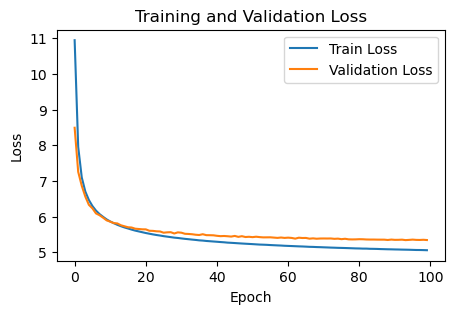

In [16]:
data = pd.read_csv('./experiments/log/log.txt', sep='\t')
plt.figure(figsize=(5, 3))
plt.plot(data['Epoch'], data['Train'], label='Train Loss')
plt.plot(data['Epoch'], data['Validation'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### Additional metrics (plots below)
- The plots below are produced for a specific temperature. Temperature effects were not investigated in this experiment, but it should be noted that higher temperatures introduce more randomness into the model as higher temperature is a key driver of entropy in folding. We used a low temperature for predictions in order to increase accuracy.
#### A) Log Probability Difference (Diff):
- This plot displays the difference in log probabilities (`Diff`) between the sampled sequences and the native sequences for the temperature used during the sampling process.
- Each point in the plot represents a protein's sampled sequence at a specific temperature, with the vertical axis showing the difference in log probabilities (`log P(sample) - log P(native)`).
- The y-axis (log probability difference) measures how close the model's predictions are to considering the sampled sequence as probable as the native sequence. A value close to zero indicates that the sampled sequence is nearly as probable as the native sequence according to the model.
- We found a median of 0.47 for the (`Diff`) which suggests that, while the native sample is considered more probable than the predicted sequences by the model, it is still reasonably probable under the model's current parameters.

#### B) Decoding Temperature vs. Native Sequence Recovery:
- This plot displays the "similarity" between the sampled sequences and the native sequences, measured as the fraction of amino acids that match the native sequence (`Native sequence recovery`).
- The y-axis shows the similarity as a fraction, ranging from 0 (no similarity) to 1 (perfect match), illustrating how well the model can recreate the native sequence under different sampling conditions.
- Higher values indicate better recovery of the native sequence, suggesting that the model is effective at predicting the correct amino acids given a protein structure.
- We found a median of 0.41 for the recovery ratio, indicating that the model correctly predicts 41% of the amino acids in the native sequence. This is reasonable and expected as, on average, only 20-50% of protein seqeunces are highly conserved, allowing for significant variability in the remaining 50-80% of amino acid positions in a protein sequence.

### A) Decoding Temperature vs, Log Probability Difference. &emsp;&emsp; B) Decoding Temp vs. Native Sequence Recovery
![Model predictions for protein 2NWM_1_A](./images/decoding_recovery.png)

In [17]:
data = pd.read_csv('./experiments/test_log/results.csv')  

# Set up the plots
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
columns = ['score', 'similarity', 'native', 'diff']
titles = {'score': "i) Distribution of log probability \n of sampled sequence", 
          'similarity': "ii) Distibution of similarity of sampled \n sequence to native sequence" , 
          'native': "iii) Distribution of log probability of native \n sequence under the model", 
          'diff': "iv) Distribution of the difference in log probabilities \n between the sampled and native sequences",}
# Plot each score in its own subplot
for ax, column in zip(axes, columns):
    data[column].plot(kind='hist', bins=20, alpha=0.75, ax=ax)
    ax.set_title(titles[column])
    ax.axvline(data[column].median(), color='r', linestyle='dashed', linewidth=1)
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')
    # Annotate the median value
    median_val = data[column].median()
    ax.annotate(f'Median: {median_val:.2f}', xy=(median_val, ax.get_ylim()[1]*0.9), xytext=(median_val, ax.get_ylim()[1]*0.9),
                arrowprops=dict(facecolor='black', shrink=0.05), horizontalalignment='left')

plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: './experiments/test_log/results.csv'

### More Distributions (above) n=7161
- i) Score: The log probability of the sampled sequence under the model, given the protein structure. A higher score indicates that the model finds the sequence more likely.
- ii) Similarity: This measures how similar the sampled sequence is to the native (actual) sequence. It's calculated as the number of matching amino acids divided by the total length of the sequence. Higher values indicate closer resemblance to the true sequence.
- iii) Native: This represents the log probability of the native sequence under the model, suggesting how likely the model thinks the true sequence is given the protein's structure.
- iv) Diff: This represents the difference in log probabilities between the sampled sequence and the native sequence. A smaller value (closer to zero) indicates that the sampled sequence is nearly as probable as the native sequence according to the model.

### Visualizing sequence predictions for a given protein:
The plot below shows the log probabilities of each of the 20 amino acids appearing at each position in the protein sequence. You can see that certain positions are highly conserved, that is there is only one amino acid that is likely appear in that position (yellow pixels). However, there are also regions with no strong prediction (all blue, or several light blue pixels for a sequence position on the x-axis). These regions have significant entropy in the amino acids sequence of a protein and are the source of variation in multiple sequence alignments. These logs are available for all proteins in the logs folder.

![Model predictions for protein 2NWM_1_A](./images/train_2NWM_1_A_probs131248.png)

### Visualizing protein structure
[AlphaFold Server](https://alphafoldserver.com/about) was used to predict the structure of the novel multiple sequence alignments for 5 proteins. First we need to export the data for some proteins which have a predicted MSA:

In [ ]:
prot_list = data['name'].tolist()
test_prots = [protein[:-3] for protein in prot_list]
test_rows = df_features[df_features['Protein_Name'].isin(test_prots)]
indexes = [1,578,1234,2777,3503] #randomly selected
for i in indexes:
    pdb_content = format_pdb_from_df(test_rows.iloc[i])
    # Write PDB to a file
    name = test_rows['Protein_Name'].iloc[i]
    with open(f"./data/{name}_test.pdb", "w") as file:
        file.write(pdb_content)

The MSA were then uploaded to AlphaFold and the structures computed. Plots of 5 distinct proteins along with 3 MSAs for each protein are visualized below. We can see that for all proteins, the MSA have visually identical structures to the native proteins.

In [ ]:
view1 = nv.show_structure_file('./alphafold/fold_1gxr_msa1/fold_1gxr_msa1_model_0.cif')
view1.clear_representations()
view1.add_representation('cartoon', color='blue')
view2 = nv.show_structure_file('./alphafold/fold_1gxr_msa2/fold_1gxr_msa2_model_0.cif')
view2.clear_representations()
view2.add_representation('cartoon', color='green')
view3 = nv.show_structure_file('./alphafold/fold_1gxr_msa3/fold_1gxr_msa3_model_0.cif')
view3.clear_representations()
view3.add_representation('cartoon', color='red')
view4 = nv.show_structure_file('./alphafold/fold_1gxr_msa4/fold_1gxr_msa4_model_0.cif')
view4.clear_representations()
view4.add_representation('cartoon', color='orange')
app_layout1 = widgets.AppLayout(
    center=widgets.HBox([view1, view2]),
    header=None, footer=None,
    left_sidebar=None, right_sidebar=None,
    pane_widths=[1, 0, 1], pane_heights=[0, 1, 0])
app_layout2 = widgets.AppLayout(
    center=widgets.HBox([view3, view4]),
    header=None, footer=None,
    left_sidebar=None, right_sidebar=None,
    pane_widths=[1, 0, 1], pane_heights=[0, 1, 0])
print("Structures for 1GXR")
ipy_display(app_layout1)
ipy_display(app_layout2)

### Note: Keep in mind that AlphaFold structures are predictions, even for known models, so it is always good to check the actual structure with NGL to make sure it is not significantly different from AlphaFold. The native strucutre below is basically identical (don't be fooled by the lack of formatting for the chains).

In [ ]:
parser = PDBParser()
structure = parser.get_structure('Sample', './data/1GXR_1_A_test.pdb')
view = nv.show_biopython(structure)
view.clear_representations()
view.add_representation('cartoon', selection='protein', color='blue')
view.add_representation('ball+stick', selection='ligand')
view

In [ ]:
view1 = nv.show_structure_file('./alphafold/fold_2i6d_msa1/fold_2i6d_msa1_model_0.cif')
view1.clear_representations()
view1.add_representation('cartoon', color='blue')
view2 = nv.show_structure_file('./alphafold/fold_2i6d_msa2/fold_2i6d_msa2_model_0.cif')
view2.clear_representations()
view2.add_representation('cartoon', color='green')
view3 = nv.show_structure_file('./alphafold/fold_2i6d_msa3/fold_2i6d_msa3_model_0.cif')
view3.clear_representations()
view3.add_representation('cartoon', color='red')
view4 = nv.show_structure_file('./alphafold/fold_2i6d_msa4/fold_2i6d_msa4_model_0.cif')
view4.clear_representations()
view4.add_representation('cartoon', color='orange')
app_layout1 = widgets.AppLayout(
    center=widgets.HBox([view1, view2]),
    header=None, footer=None,
    left_sidebar=None, right_sidebar=None,
    pane_widths=[1, 0, 1], pane_heights=[0, 1, 0])
app_layout2 = widgets.AppLayout(
    center=widgets.HBox([view3, view4]),
    header=None, footer=None,
    left_sidebar=None, right_sidebar=None,
    pane_widths=[1, 0, 1], pane_heights=[0, 1, 0])
print("Structures for 2I6D")
ipy_display(app_layout1)
ipy_display(app_layout2)

In [ ]:
view1 = nv.show_structure_file('./alphafold/fold_3tpd_msa1/fold_3tpd_msa1_model_0.cif')
view1.clear_representations()
view1.add_representation('cartoon', color='blue')
view2 = nv.show_structure_file('./alphafold/fold_3tpd_msa2/fold_3tpd_msa2_model_0.cif')
view2.clear_representations()
view2.add_representation('cartoon', color='green')
view3 = nv.show_structure_file('./alphafold/fold_3tpd_msa3/fold_3tpd_msa3_model_0.cif')
view3.clear_representations()
view3.add_representation('cartoon', color='red')
view4 = nv.show_structure_file('./alphafold/fold_3tpd_msa4/fold_3tpd_msa4_model_0.cif')
view4.clear_representations()
view4.add_representation('cartoon', color='orange')
app_layout1 = widgets.AppLayout(
    center=widgets.HBox([view1, view2]),
    header=None, footer=None,
    left_sidebar=None, right_sidebar=None,
    pane_widths=[1, 0, 1], pane_heights=[0, 1, 0])
app_layout2 = widgets.AppLayout(
    center=widgets.HBox([view3, view4]),
    header=None, footer=None,
    left_sidebar=None, right_sidebar=None,
    pane_widths=[1, 0, 1], pane_heights=[0, 1, 0])
print("Structures for 3TPD - Notice the loop missing in the red structure")
ipy_display(app_layout1)
ipy_display(app_layout2)

In [ ]:
view1 = nv.show_structure_file('./alphafold/fold_4mu9_msa1/fold_4mu9_msa1_model_0.cif')
view1.clear_representations()
view1.add_representation('cartoon', color='blue')
view2 = nv.show_structure_file('./alphafold/fold_4mu9_msa2/fold_4mu9_msa2_model_0.cif')
view2.clear_representations()
view2.add_representation('cartoon', color='green')
view3 = nv.show_structure_file('./alphafold/fold_4mu9_msa3/fold_4mu9_msa3_model_0.cif')
view3.clear_representations()
view3.add_representation('cartoon', color='red')
view4 = nv.show_structure_file('./alphafold/fold_4mu9_msa4/fold_4mu9_msa4_model_0.cif')
view4.clear_representations()
view4.add_representation('cartoon', color='orange')
app_layout1 = widgets.AppLayout(
    center=widgets.HBox([view1, view2]),
    header=None, footer=None,
    left_sidebar=None, right_sidebar=None,
    pane_widths=[1, 0, 1], pane_heights=[0, 1, 0])
app_layout2 = widgets.AppLayout(
    center=widgets.HBox([view3, view4]),
    header=None, footer=None,
    left_sidebar=None, right_sidebar=None,
    pane_widths=[1, 0, 1], pane_heights=[0, 1, 0])
print("Structures for 4MU9|")
ipy_display(app_layout1)
ipy_display(app_layout2)

In [ ]:
view1 = nv.show_structure_file('./alphafold/fold_1rff_msa1/fold_1rff_msa1_model_0.cif')
view1.clear_representations()
view1.add_representation('cartoon', color='blue')
view2 = nv.show_structure_file('./alphafold/fold_1rff_msa2/fold_1rff_msa2_model_0.cif')
view2.clear_representations()
view2.add_representation('cartoon', color='green')
view3 = nv.show_structure_file('./alphafold/fold_1rff_msa3/fold_1rff_msa3_model_0.cif')
view3.clear_representations()
view3.add_representation('cartoon', color='red')
view4 = nv.show_structure_file('./alphafold/fold_1rff_msa3/fold_1rff_msa3_model_0.cif')
view4.clear_representations()
view4.add_representation('cartoon', color='orange')
app_layout1 = widgets.AppLayout(
    center=widgets.HBox([view1, view2]),
    header=None, footer=None,
    left_sidebar=None, right_sidebar=None,
    pane_widths=[1, 0, 1], pane_heights=[0, 1, 0])
app_layout2 = widgets.AppLayout(
    center=widgets.HBox([view3, view4]),
    header=None, footer=None,
    left_sidebar=None, right_sidebar=None,
    pane_widths=[1, 0, 1], pane_heights=[0, 1, 0])
print("Structures for 1RFF")
ipy_display(app_layout1)
ipy_display(app_layout2)

## Conclusions: 
- This model is effective for generating MSAs with similar structure to a given protein.
- In the future it would be useful to use a metric to compute how close the predicted structures of each of the MSAs is to the known native protein structure.

# PART 2 - Novel sequence 